# 1. Introduction

This notebook explores a speed dating dataset from Kaggle and in the end tries to predict the decision a partner makes at the event (yes or no to a date)

## Setup


In [18]:
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #We need this to split the data
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics


df = pd.read_csv('speed_dating_data.csv', encoding="ISO-8859-1") #encoding to prevent errors while importing
df.head()



,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


# 2. Data Cleaning

### 2.1 inspect data frames

In [19]:
df.shape #inspect features/rows


(8378, 195)

This data set has 195 features which we are going to subset for better handling

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 195 entries, iid to amb5_3
dtypes: float64(174), int64(13), object(8)
memory usage: 12.5+ MB


### 2.2 investigating focus features

We will focus on 7 features that intuitively determine if a partner likes you or not

In [21]:
df.groupby(['gender'])['iid'].count().reset_index()

,gender,iid
0,0,4184
1,1,4194


Our dataset contains about 50/50 males and females. From the documentation it seems that all participants were heterosexual (? not sure, but several questions begin with 'what are you looking for in the opposite sex). If this assumption holds, it is likely that gender is a good prediction for liking somebody. 

In [22]:
df['age_o'].describe()

count    8274.000000
mean       26.364999
std         3.563648
min        18.000000
25%        24.000000
50%        26.000000
75%        28.000000
max        55.000000
Name: age_o, dtype: float64

Most people will likely seek somebody in their own age range. Age is a float variable between 18 and 55, but it seems the largest part is relatively young (in their twenties).

Now, do we care about **money** ? Let's include _income_ just to be sure. 


In [23]:
df['income'].isnull().sum()

4099

Okay, let's not do that, since we have a lot of missing values there.

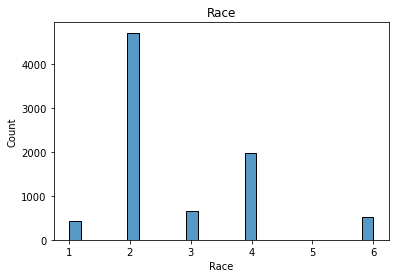

In [24]:
sns.histplot(df['race_o'].dropna(), kde=False) 
plt.title('Race')
plt.xlabel('Race')
plt.show()

	Black/African American=1
	European/Caucasian-American=2
	Latino/Hispanic American=3
	Asian/Pacific Islander/Asian-American=4
	Native American=5
	Other=6

This dataset contains of mostly caucasian and asian participants. 

Next we investigate if this matters for people with the variable -->
imprace:
How important is it to you (on a scale of 1-10) that a person you date be of the same racial/ethnic background?


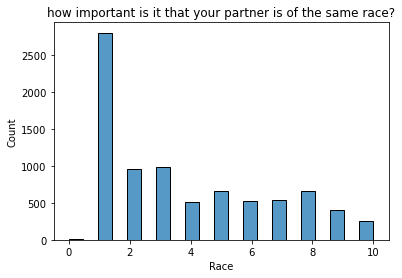

In [25]:
sns.histplot(df['imprace'].dropna(), kde=False) 
plt.title('how important is it that your partner is of the same race?')
plt.xlabel('Race')
plt.show()

It seems that it is not really that relevant for most people, but there is still a group that seems to care a lot and therefore might allow for better prediction (even if this intuition doesn't really feel good to add...)

We use the dummy variable:
samerace:  	participant and the partner were the same race. 1= yes, 0=no

Most people care about the looks about their partners. The dataset uses an attraction attribute. We will first look at: 
*How do you think you measure up?*
*Please rate your opinion of your own attributes, on a scale of 1-10 (be honest!):*
*attr3_1*
*Attractive*
This is an self evaluated measure of attractiveness




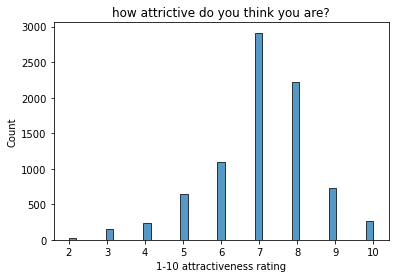

In [26]:
sns.histplot(df['attr3_1'].dropna(), kde=False) 
plt.title('how attrictive do you think you are?')
plt.xlabel('1-10 attractiveness rating')
plt.show()

However, it off course seems most important what the partner thinks of you, but we are not so shallow that only attractiveness matters. We therefore focus on several other attributes in the dataset that are ranked by the partner: 
- attractiveness
- sincerity 
- intelligence
- fun 
- ambitious 
- shared interests

This is captured by the following variables:
- attr_o
- sinc_o
- intel_o
- fun_o
- amb_o
- share_o

### 2.3 subsetting dataset

now subset the dataset on the previously narrowed down set of variables. (i've deliberately not chosen to include 'aggregate' variables such as 'how much do you like the partner' since this is likely very correlated with the decision and doesn't tell us something specifically about what makes it that you like someone.)

In [27]:
df = df[['gender', 'age_o', 'samerace', 'attr3_1', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'dec_o']]
df.head()

,gender,age_o,samerace,attr3_1,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,dec_o
0,0,27.0,0,6.0,6.0,8.0,8.0,8.0,8.0,6.0,0
1,0,22.0,0,6.0,7.0,8.0,10.0,7.0,7.0,5.0,0
2,0,22.0,1,6.0,10.0,10.0,10.0,10.0,10.0,10.0,1
3,0,23.0,0,6.0,7.0,8.0,9.0,8.0,9.0,8.0,1
4,0,24.0,0,6.0,8.0,7.0,9.0,6.0,9.0,7.0,1


In [28]:
df=df.dropna()
df.shape

(6870, 11)

We lose 8378-6870= **1492** observations after dropping the nans

In [29]:
df.describe()

,gender,age_o,samerace,attr3_1,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,dec_o
count,6870.000000,6870.000000,6870.000000,6870.000000,6870.000000,6870.000000,6870.000000,6870.000000,6870.000000,6870.000000,6870.000000
mean,0.491412,26.237263,0.397089,7.085007,6.182300,7.155895,7.349782,6.393159,6.750582,5.454512,0.430713
std,0.499963,3.464002,0.489330,1.401201,1.953274,1.749739,1.561240,1.957106,1.799163,2.147665,0.495212
min,0.000000,18.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,0.000000,6.000000,5.000000,6.000000,6.000000,5.000000,6.000000,4.000000,0.000000
50%,0.000000,26.000000,0.000000,7.000000,6.000000,7.000000,7.000000,7.000000,7.000000,6.000000,0.000000
75%,1.000000,28.000000,1.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,1.000000
max,1.000000,55.000000,1.000000,10.000000,10.000000,10.000000,10.000000,11.000000,10.000000,10.000000,1.000000


All subsetted variables seem correct without any weird outliers in things like age. The variables gender and samerace are always 0/1, but the other variables don't always follow a 1-10 scale like in the survey. This means the 0 values are incorrect so we will exclude those.

In [30]:
df = df[(df['sinc_o'] > 0)] #exclude 0 variables
df = df[(df['intel_o'] > 0)] #exclude 0 variables
df = df[(df['fun_o'] > 0)] #exclude 0 variables
df = df[(df['amb_o'] > 0)] #exclude 0 variables
df = df[(df['shar_o'] > 0)] #exclude 0 variables
df = df[(df['attr_o'] > 0)] #exclude 0 variables


**Our finale dataset consists of 6806 logical observations**

# 3. Exploratory Analysis

### 3.1 heatmap

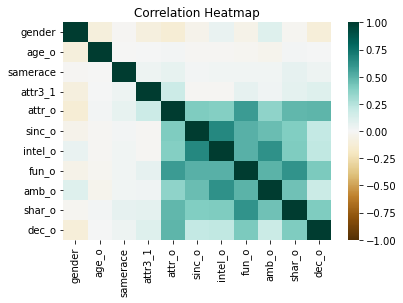

In [31]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Correlation Heatmap',);

we will look at the last row. It seems that the decision is mostly positively correlated with attractiveness, fun and shared interests.  Another interesting fact is that ambition is also correlated positively with gender. Indicating that males are more ambitious. Race and age don't seem to matter that much in our dataset. 

### 3.2 Box plot

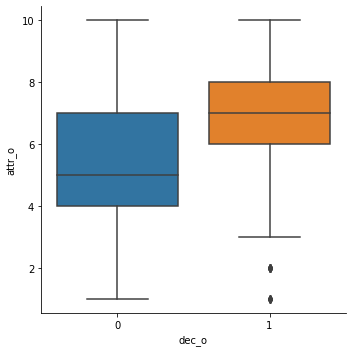

In [32]:
sns.catplot(x="dec_o", y="attr_o", kind="box", data=df)

Our distribution indeed shows that when people like the other person they generally also find them more attractive and never really unattractive (1)

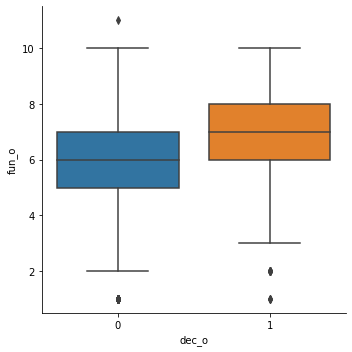

In [33]:
sns.catplot(x="dec_o", y="fun_o", kind="box", data=df)

We find similar results for the other person being funny, but they are closer together. this indicates that being fun alone is not important enough to like somebody. It is therefore a good decision to include multiple attributes

# 4. Predictive model

the chosen model is random forest. It works by creating multiple decisions trees and then the outcome is based on what most trees decide upon. 

In [35]:
#preparing the model
X = df.loc[:, 'gender':'shar_o']
y = df['dec_o'] #create the y-variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #split the data, store it into different variables

In [36]:
clf=RandomForestClassifier(n_estimators=100) #100, 500, 3000

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# 5. Evaluation

In [37]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.757590597453477


The model is able to predict 75% of the outcomes in the test data set correctly

In [39]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred) #creates a "confusion matrix"

#In order to read it easily , let's make a dataframe out of it, and add labels to it.
conf_matrix = pd.DataFrame(cm, index=['No Date', 'Date',], columns = ['No Date Predicted', 'Date Predicted']) 
conf_matrix

,No Date Predicted,Date Predicted
No Date,949,211
Date,284,598


<AxesSubplot:>

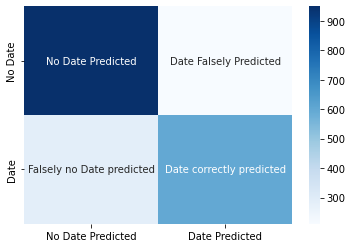

In [41]:
labels = ['No Date Predicted','Date Falsely Predicted', 'Falsely no Date predicted', 'Date correctly predicted']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

- $$Accuracy \\ = 949 + 598 / 949 + 598 + 211 + 284 = 1574 / 2042 = 77 (not correct somehow)$$
- $$ Precision date \\ = 598 / 598 + 211 = 598 / 809 = 0,74$$
- $$Recall date \\ = 598 / 882 = 0,68$$

In [40]:
#build in function for precision recall used to check my calculations above
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1160
           1       0.74      0.68      0.71       882

    accuracy                           0.76      2042
   macro avg       0.75      0.75      0.75      2042
weighted avg       0.76      0.76      0.76      2042



The precision of 0,74 means that in 74% of all predicted dates it actually is a date (or match/1). This is reasonable with just 7 variables, but I would have guess better results with clear variables like 'attraction, humor etc'.

The recall is lower with 0,68. This means that of all actual dates only 68% was predicted as an actual date. 

# 6. Conclusion

- Our model is not as good in predicting if the other person likes the person it dates as i thought it would. We include 'clear' variables such as attraction scores, humor etc. I guess this would have been sufficient, but apparently people are more complicated than 7 likert scale questions. ;) 

In [42]:
print('test')

test
